In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import cv2

%matplotlib ipympl

In [2]:
datapath = './data'
fn = os.path.join(datapath, 'train', '0000.npz')
sequence = np.load(fn)
print(sequence.keys())

KeysView(NpzFile './data/train/0000.npz' with keys: events, timestamps, traj, range_meter)


In [3]:
events = sequence['events']
t = sequence['timestamps'] 
x = sequence['traj']
rm = sequence['range_meter']

In [6]:
ev_data = pd.DataFrame(events)
print(ev_data)

           x    y      p         t
0        191   47   True     12000
1         67   46   True     13000
2         34   34   True     14000
3        182   37   True     14000
4        188   60  False     14000
...      ...  ...    ...       ...
6303273   55   31   True  47362000
6303274  135  138  False  47362000
6303275   11   51   True  47362000
6303276   28   55  False  47362000
6303277  196   77   True  47362000

[6303278 rows x 4 columns]


In [7]:
ts_data = pd.DataFrame(t, columns=['time/s'])
print(ts_data)

        time/s
0     0.000000
1     0.394692
2     0.789383
3     1.184075
4     1.578766
..         ...
115  45.389527
116  45.784218
117  46.178910
118  46.573601
119  46.968293

[120 rows x 1 columns]


In [8]:
traj_data = pd.DataFrame(x, columns=['x', 'y', 'z', 'vx', 'vy', 'vz','roll', 'pitch', 'yaw','wr', 'wp', 'wy'])
print(traj_data)

              x            y            z        vx          vy         vz  \
0    142.319909 -5368.903929 -2443.942470 -4.060269  153.730388  51.283123   
1    140.717355 -5308.227846 -2423.575046 -4.060269  153.730388  51.923668   
2    139.114802 -5247.551762 -2402.954805 -4.060269  153.730388  52.564213   
3    137.512248 -5186.875679 -2382.081746 -4.060269  153.730388  53.204758   
4    135.909694 -5126.199596 -2360.955870 -4.060269  153.730388  53.845303   
..          ...          ...          ...       ...         ...        ...   
115    1.931251   -98.906305  -190.647991 -0.702253   30.941540  11.745956   
116    1.665808   -87.069816  -186.142667 -0.642767   29.035916  11.084540   
117    1.423867   -75.986609  -181.897328 -0.583325   27.124477  10.428551   
118    1.205247   -65.658978  -177.909830 -0.524593   25.207227   9.778000   
119    1.009521   -56.089216  -174.178026 -0.467671   23.284159   9.132885   

         roll     pitch       yaw        wr        wp          

In [9]:
rm_data = pd.DataFrame(rm, columns=['time/s', 'd/m'])
print(rm_data)

     time/s         d/m
0       0.1  2788.99900
1       0.2  2782.20600
2       0.3  2777.18630
3       0.4  2771.72270
4       0.5  2766.56400
..      ...         ...
468    46.9   303.03070
469    47.0   301.67730
470    47.1   300.38670
471    47.2   299.09300
472    47.3   297.92566

[473 rows x 2 columns]


In [12]:
divider = 1

ts_data_new = pd.DataFrame(columns=['time/s'])

for i in range(0, ts_data.shape[0]):
    # print(i)
    if (i != ts_data.shape[0] - 1):
        time_gap = ts_data['time/s'][i + 1] - ts_data['time/s'][i]
        # print(timegap)
        time_gap_new = time_gap / divider
        for j in range(0, divider):
            ts_new = ts_data['time/s'][i] + time_gap_new * j
            # print(ts_new)
            ts_data_new.loc[len(ts_data_new.index)] = [ts_new]
    else:
        ts_data_new.loc[len(ts_data_new.index)] = [ts_data['time/s'][i]]
            
# print(ts_data_new)  

# print(ts_data_new.shape[0])

ts_us = (ts_data_new['time/s'] * 1e6).tolist()
event_groups_list = []
for i in range(len(ts_us)):
    if (i != len(ts_us) - 1): 
        ts_0 = ts_us[i]
        ts_1 = ts_us[i+1]
        group_df = ev_data.loc[ev_data['t'].between(ts_0, ts_1, inclusive='left'), ['x','y','t']]
    else:
        ts_0 = ts_us[i]
        ts_1 = 2 * ts_0 - ts_us[i - 1]
        group_df = ev_data.loc[ev_data['t'].between(ts_0, ts_1, inclusive='left'), ['x','y','t']]
    if not group_df.empty:
        event_groups_list.append((ts_0, ts_1, group_df))

In [13]:
i = 0
ts_0, ts_1, df = event_groups_list[0]
print(len(df))

24343


In [ ]:
# print(df)

ev_frame = np.zeros([200,200,3], dtype=np.uint8)

window = ts_1 - ts_0
w1 = ts_0 + window / 3
w2 = ts_1 - window / 3

red_ev = df.loc[df['t'].between(ts_0, w1), ['x','y','t']]
green_ev = df.loc[df['t'].between(w1, w2), ['x','y','t']]
blue_ev = df.loc[df['t'].between(w2, ts_1), ['x','y','t']]

x = red_ev['x'].to_numpy()
y = red_ev['y'].to_numpy()
t = red_ev['t'].to_numpy()

alpha = (t - ts_0) / window

for i in range(len(x)):
    ev_frame[y[i], x[i], 0] = alpha[i] * 255.0

x = green_ev['x'].to_numpy()
y = green_ev['y'].to_numpy()
t = green_ev['t'].to_numpy()

alpha = (t - ts_0) / window

for i in range(len(x)):
    ev_frame[y[i], x[i], 1] = alpha[i] * 255.0

x = blue_ev['x'].to_numpy()
y = blue_ev['y'].to_numpy()
t = blue_ev['t'].to_numpy()

alpha = (t - ts_0) / window

for i in range(len(x)):
    ev_frame[y[i], x[i], 2] = alpha[i] * 255.0

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(ev_frame)
ax.set_title('Event Visualization')
plt.show()

In [10]:
def create_temporal_rgb_frame(df, ts_0, ts_1, height=200, width=200):
    """
    将一个时间窗口的事件DataFrame，根据时间先后顺序渲染到RGB三通道上。
    input:
        df (pd.DataFrame): 包含 ['x', 'y', 't'] 列的事件数据。
        ts_0: 时间窗口的起始时间 (微秒)。
        ts_1: 时间窗口的结束时间 (微秒)。
        height: 输出图像的高度。
        width: 输出图像的宽度。

    output:
        np.ndarray: 一个 (height, width, 3) 的uint8类型的RGB图像。
    """
    ev_frame = np.zeros([height, width, 3], dtype=np.uint8)
    
    if df.empty or (ts_1 <= ts_0):
        return ev_frame

    window = ts_1 - ts_0
    w1 = ts_0 + window / 3
    w2 = ts_1 - window / 3

    # --- 处理红色通道 (时间段 1/3) ---
    red_ev = df.loc[df['t'].between(ts_0, w1)]
    if not red_ev.empty:
        x = red_ev['x'].to_numpy()
        y = red_ev['y'].to_numpy()
        t = red_ev['t'].to_numpy()
        
        alpha = (t - ts_0) / window
        ev_frame[y, x, 0] = np.clip(alpha * 255.0, 0, 255)

    # --- 处理绿色通道 (时间段 2/3) ---
    green_ev = df.loc[df['t'].between(w1, w2)]
    if not green_ev.empty:
        x = green_ev['x'].to_numpy()
        y = green_ev['y'].to_numpy()
        t = green_ev['t'].to_numpy()

        alpha = (t - ts_0) / window
        ev_frame[y, x, 1] = np.clip(alpha * 255.0, 0, 255)

    # --- 处理蓝色通道 (时间段 3/3) ---
    blue_ev = df.loc[df['t'].between(w2, ts_1)]
    if not blue_ev.empty:
        x = blue_ev['x'].to_numpy()
        y = blue_ev['y'].to_numpy()
        t = blue_ev['t'].to_numpy()

        alpha = (t - ts_0) / window
        ev_frame[y, x, 2] = np.clip(alpha * 255.0, 0, 255)
        
    return ev_frame

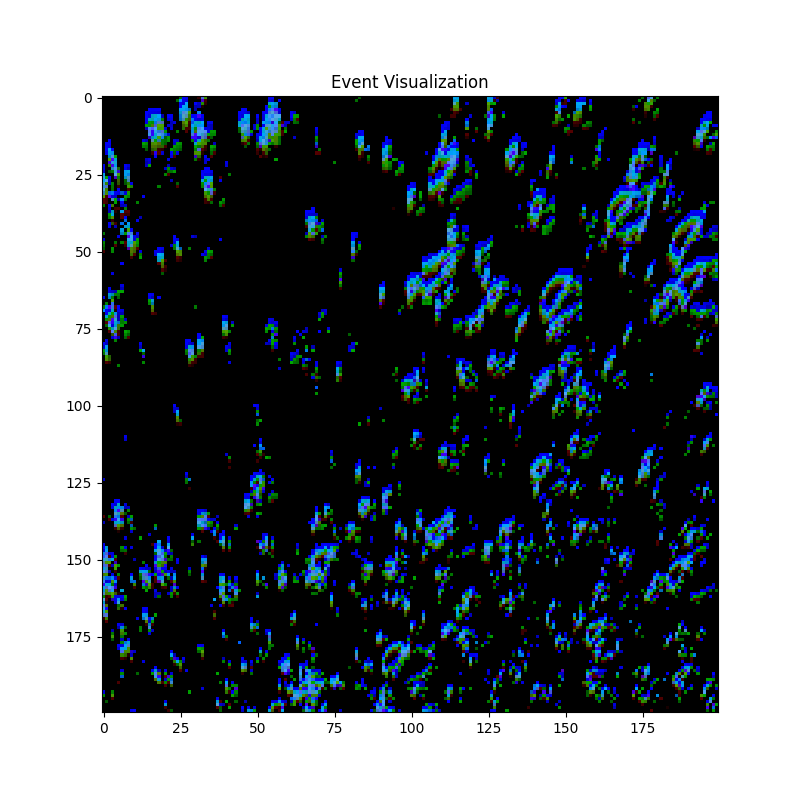

In [14]:
frame = create_temporal_rgb_frame(df, ts_0, ts_1)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(frame)
ax.set_title('Event Visualization')
plt.show()

In [13]:
def generate_event_images(filename, domain='train' , outdir='./dataset', divider=1, img_height=200, img_width=200):
    """
    根据输入的npz文件，产生所有时间窗口的rgb图像
    Args:
        filename (str): 读取的npz文件名 (不含扩展名)。
        domain (str): 'train' 或 'test' 等子目录。
        outdir (str): 输出数据的根文件夹。
        divider (int): 时间戳间隔的细分数量。
        img_height (int): 输出图像的高度。
        img_width (int): 输出图像的宽度。
    """
    datapath = './data'
    fpath = os.path.join(datapath, domain, filename + '.npz')
    outpath = os.path.join(outdir, domain, filename + '_' + str(divider), 'img')
    os.makedirs(outpath, exist_ok=True)
    
    sequence = np.load(fpath)
    events = sequence['events']
    timestamps = sequence['timestamps'] 
    traj = sequence['traj']
    range_meter = sequence['range_meter']

    ev_data = pd.DataFrame(events)
    # ts_data = pd.DataFrame(t, columns=['time/s'])
    # traj_data = pd.DataFrame(x, columns=['x', 'y', 'z', 'vx', 'vy', 'vz', 'roll', 'pitch', 'yaw','wr', 'wp', 'wy'])
    # rm_data = pd.DataFrame(rm, columns=['time/s', 'd/m'])
    
    new_ts_list = []
    for i in range(len(timestamps) - 1):
        start_time = timestamps[i]
        end_time = timestamps[i+1]
        interpolated_times = np.linspace(start_time, end_time, divider, endpoint=False)
        new_ts_list.append(interpolated_times)
    
    new_ts_list.append(np.array([timestamps[-1]]))

    ts_us = np.concatenate(new_ts_list) * 1e6
    event_groups_list = []

    for i in tqdm(range(len(ts_us))):
        if (i != len(ts_us) - 1): 
            ts_0 = ts_us[i]
            ts_1 = ts_us[i+1]
            df = ev_data.loc[ev_data['t'].between(ts_0, ts_1, inclusive='left'), ['x','y','t']]
        else:
            ts_0 = ts_us[i]
            ts_1 = 2 * ts_0 - ts_us[i - 1]
            df = ev_data.loc[ev_data['t'].between(ts_0, ts_1, inclusive='left'), ['x','y','t']]
            
        rgb_frame = create_temporal_rgb_frame(df, ts_0, ts_1, img_height, img_width)
        bgr_frame = cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2BGR)
        imgname = os.path.join(outpath, f"{i:03d}.png")
        cv2.imwrite(imgname, bgr_frame)

    print(f"Save {len(ts_us)} imgs at {outpath}. ")     

In [37]:
generate_event_images('0000', divider=2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:21<00:00, 11.12it/s]

Save 239 imgs at ./dataset/train/0000_2/img. 


In [34]:
def generate_traj_data(filename, domain='train' , outdir='./dataset', divider=1):
    """
    根据输入的npz文件，产生所有时间窗口的轨迹的插值
    Args:
        filename (str): 读取的npz文件名 (不含扩展名)。
        domain (str): 'train' 或 'test' 等子目录。
        outdir (str): 输出数据的根文件夹。
        divider (int): 时间戳间隔的细分数量。
    """
    datapath = './data'
    fpath = os.path.join(datapath, domain, filename + '.npz')
    outpath = os.path.join(outdir, domain, filename + '_' + str(divider), 'data')
    os.makedirs(outpath, exist_ok=True)
    
    sequence = np.load(fpath)
    # events = sequence['events']
    # timestamps = sequence['timestamps'] 
    traj = sequence['traj']
    # range_meter = sequence['range_meter']

    # ev_data = pd.DataFrame(events)
    # ts_data = pd.DataFrame(t, columns=['time/s'])
    # traj_data = pd.DataFrame(x, columns=['x', 'y', 'z', 'vx', 'vy', 'vz', 'roll', 'pitch', 'yaw','wr', 'wp', 'wy'])
    # rm_data = pd.DataFrame(rm, columns=['time/s', 'd/m'])

    traj_new_list = []

    if divider == 1:
        traj_new = traj
    else: 
        for i in range(len(traj) - 1):
            start_vec = traj[i] 
            end_vec = traj[i+1] 
            interpolated_vec = np.linspace(start_vec, end_vec, divider, endpoint=False)
            traj_new_list.append(interpolated_vec)

        traj_new_list.append(traj[-1].reshape(1, -1))
        traj_new = np.concatenate(traj_new_list, axis=0)
    
    df = pd.DataFrame(traj_new, columns=['x', 'y', 'z', 'vx', 'vy', 'vz', 'roll', 'pitch', 'yaw','wr', 'wp', 'wy'])
    csvpath = os.path.join(outpath, 'trajectory.csv')
    df.to_csv(csvpath, index=False)
    print(f"Save {len(df)} lines of trajectory data to {csvpath}.")

In [36]:
generate_traj_data('0000', divider=2)

Save 239 lines of trajectory data to ./dataset/train/0000_2/data/trajectory.csv.
